# Cleaning our main dataset to use in modeling

This script does the following:
- Loads our main joined dataset and medical diagnoses data
- Cleans the above datsets
- Performs the following feature engineering:
  - Compute rolling averages of prior pm2.5 levels
  - One-hot encode categorical features: school_region, month
  - Get year from date

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in Data

In [3]:
# read in full joined dataset:
df = pd.read_parquet(os.path.join(data_path, 'joined_data/joined_open_schools_only_10-10-22.parquet'))
df = df.reset_index(drop=True)

# read cornelia med data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]

# temperature data
df_schools_temp = pd.read_parquet(os.path.join(data_path, 'temperature/schools_temp_lookup.parquet'))
df_ps_temp = pd.read_parquet(os.path.join(data_path, 'temperature/point_poll_sources_temp_lookup.parquet'))

# Clean Medical Data

Join the three medical files into 1 file

In [4]:
# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + df2['patzip_year_month'].to_list() + df3['patzip_year_month'].to_list()
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')

df_med.head(3)

,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab
0,92881-2014-11,1.0,18.0,NaN,NaN,1.0,20.0
1,94566-2006-11,1.0,18.0,NaN,NaN,NaN,NaN
2,93212-2007-3,1.0,17.0,NaN,NaN,NaN,NaN


# Clean Main Data

In [5]:
print(f'starting row count: {df.shape[0]}')

# clean up column names. Make them all lower cased, and replace spaces with "_"
df.columns = df.columns.str.replace("\.*\s+", "_").str.lower()

# fix some datatypes
num_vars = ['angle_to_school', 'ps_elevation_m', 'pm25', 'point_source_pm25_tpy', 
            'dist_school_to_ps_m', 'angle_to_school', 'avg_wind_alignment_cosine',
            'total_population', 'total_population_male', 'total_population_female', 
            'population_0_4', 'population_0_4_male', 'population_0_4_female',
            'population_5_9', 'population_5_9_male', 'population_5_9_female',
            'population_10_14', 'population_10_14_male', 'population_10_14_female',
            'population_15_19', 'population_15_19_male', 'population_15_19_female',
            'total_pop_under19', 'point_source_lat', 'point_source_lon']

for var in num_vars:
  df[var] = df[var].astype(float)

# filter out na pm2.5 values (133,261 of them)
df = df[~df['pm25'].isna()]

# 1,584 records are missing population in the year 2000. B/c the 2000 data had less zip codes.
# Filter them out since we aren't using 2000 anyways. 
df = df[~df['population_10_14'].isna()]

# mean impute these vars
mean_impute_vars = ['ca_agi_per_returns', 'total_tax_liability']
for var in mean_impute_vars:
  df[var] = df[var].fillna(df[var].mean())

# 3 zips have 0 population, just filter those out
df = df[df['total_population'] != 0]

# get tax per capita (watch out for inf and nan)
df['tax_liability_per_capita'] = df['total_tax_liability'] / df['total_population']

print(f'ending row count: {df.shape[0]}')

starting row count: 2471552
ending row count: 2336347


# Group the Data

In [6]:
# pre-grouping checks:
n = df[['year_month', 'school_zip']].drop_duplicates().shape[0]
print(f'count of distinct year-mo-zips: {n}')

# including the population counts in this
n = df[['year_month', 'school_zip', 'school_county_v2', 'school_region_name',
  'pop_under19_male', 'pop_under19_female', 'total_pop_under19', 'pm25', 
  'ca_agi_per_returns', 'total_tax_liability']]\
  .drop_duplicates().shape[0]
print(f'count of distinct for all join vars: {n}')

count of distinct year-mo-zips: 312009
count of distinct for all join vars: 312009


In [7]:
# maybe not all of these should use 'mean', but doing it this way for now. 
mean_vars = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'ps_elevation_m', 'point_source_pm25_tpy', 
  'dist_school_to_ps_m', 'angle_to_school', 'ps_wspd_merge', 'school_wdir_wrt_0n', 'ps_wdir_wrt_0n', 
  'school_wind_alignment', 'ps_wind_alignment', 'avg_wind_speed', 'avg_wind_alignment', 'avg_wind_alignment_cosine',
  'nearby_point_source_count', 'ca_agi_per_returns', 'total_tax_liability', 'tax_liability_per_capita',

  # populations
  'population_0_4', 'population_0_4_male', 'population_0_4_female', 
  'population_5_9', 'population_5_9_male', 'population_5_9_female', 
  'population_10_14', 'population_10_14_male', 'population_10_14_female', 
  'population_15_19', 'population_15_19_male','population_15_19_female', 
  'total_pop_under19', 'pop_under19_male', 'pop_under19_female', 
  'total_population', 'total_population_male', 'total_population_female', 
  ]

count_vars = ['cdscode']

mean_dict = {var:(var, 'mean') for var in mean_vars}
count_dict = {var:(var, 'count') for var in count_vars}
agg_dict = {**mean_dict, **count_dict}

grp_vars = ['year_month', 'school_zip', 'school_county_v2', 'school_region_name', 'pm25']

df_grp = df\
  .groupby(grp_vars)\
  .agg(**agg_dict)\
  .reset_index()

df_grp = df_grp.rename(columns = {'cdscode':'school_count'})

print(f'Num rows of grouped df: {df_grp.shape[0]}')

Num rows of grouped df: 312009


# Create rolling avg of pm2.5 (6, 9, and 12 month)

In [8]:
# create a df rolling avg
df_avgs = df_grp[['year_month', 'school_zip', 'pm25']].sort_values(['school_zip', 'year_month'])

# get rolling n month avg
def create_rolling_avg(df, num_months=6):
  df[f'pm25_r{num_months}'] = df.groupby('school_zip')['pm25']\
    .apply(lambda x: x.rolling(window=num_months, min_periods=num_months, closed='left').mean())
    
  return df 


df_avgs = create_rolling_avg(df_avgs, 1)
df_avgs = create_rolling_avg(df_avgs, 6)
df_avgs = create_rolling_avg(df_avgs, 9)
df_avgs = create_rolling_avg(df_avgs, 12)
df_avgs = create_rolling_avg(df_avgs, 24)

# count num obs over past n months (don't need this, but keeping it commented just in case)
# df_avgs['pm25_6mo_count'] = df_avgs.groupby('school_zip')['pm25'].apply(lambda x: x.rolling(6, 1, closed='left').apply(lambda x: len(x)))
# df_avgs['pm25_9mo_count'] = df_avgs.groupby('school_zip')['pm25'].apply(lambda x: x.rolling(9, 1, closed='left').apply(lambda x: len(x)))
# df_avgs['pm25_12mo_count'] = df_avgs.groupby('school_zip')['pm25'].apply(lambda x: x.rolling(12, 1, closed='left').apply(lambda x: len(x)))

# get pm25 for last month
df_avgs = df_avgs.rename(columns={'pm25_r1': 'pm25_last_month'})

Find trend
- This feature will be very correlated with the `pm25_last_month` feature. Discuss with cornelia whether there is an issue with multiple colinearity. 

In [9]:
def get_slope_pm25_per_month(df, num_months=6):
    def calcSlope(y):
        regr = LinearRegression()
        x_temp = np.array(list(range(len(y)))).reshape(-1, 1)

        try:
            regr.fit(x_temp, y)
            return regr.coef_[0]
        except:
            return None
    
    df[f'pm25_slope{num_months}'] = df.groupby('school_zip')['pm25']\
      .apply(lambda x: x.rolling(window=num_months, min_periods=num_months, closed='left')\
      .apply(lambda y: calcSlope(y)))

    return df

In [10]:
df_avgs = get_slope_pm25_per_month(df_avgs, 6)
df_avgs = get_slope_pm25_per_month(df_avgs, 9)
df_avgs = get_slope_pm25_per_month(df_avgs, 12)
df_avgs = get_slope_pm25_per_month(df_avgs, 24)

In [11]:
# get pm2.5 value from 12 months ago
df_avgs['pm25_lag_12mo'] = df_avgs.groupby('school_zip')['pm25'].shift(12)

5 schools have some time gaps. But only 5 of them. So not too much to worry about.

In [12]:
df_avgs['num_days'] = df_avgs.groupby('school_zip')['year_month'].apply(lambda x: x.diff())
df_avgs.value_counts('num_days')

num_days
31 days      180622
30 days      103992
28 days       19193
29 days        6809
92 days           1
458 days          1
761 days          1
762 days          1
1188 days         1
1553 days         1
dtype: int64

Join the rolling averages back to main dataset

In [13]:
# drop columns we don't need:
df_avgs = df_avgs.drop(columns=['pm25', 'num_days'])
# join them
df_grp = pd.merge(df_grp, df_avgs, on=['school_zip', 'year_month'], how='left')

Join the med data

In [14]:
df_grp['zip_year_month'] = df_grp['school_zip'].astype(str) + '-' +\
  df_grp['year_month'].dt.year.astype(str) + '-' +\
  df_grp['year_month'].dt.month.astype(str)

df_grp = pd.merge(df_grp, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 'pediatric_vasculitis', 
  'number_of_visits_vasc', 'type_1_diabetes', 'number_of_visits_diab']
for var in med_vars:
  df_grp[var] = df_grp[var].fillna(0)

print(df_grp.shape[0])

312009


In [15]:
df_grp = df_grp.drop(columns = ['zip_year_month', 'patzip_year_month'])

## One-hot encode categorical features
- School region
- Month

In [16]:
# create year var
df_grp['year'] = df_grp['year_month'].dt.year

# create month. convert to string and make it two digits so we can one-hot encode
df_grp['month'] = df_grp['year_month'].dt.month.map(lambda x: str(x).rjust(2, '0'))

In [17]:
encode_cols = ['school_region_name', 'month']

df_one_hot = pd.get_dummies(df_grp[['year_month', 'school_zip'] + encode_cols])
df_one_hot.columns = df_one_hot.columns.str.replace("\.*\s+", "_").str.lower()

#df_grp = pd.merge(df_grp.drop(columns=encode_cols), df_one_hot, on=['year_month', 'school_zip'], how='left')
df_grp = pd.merge(df_grp, df_one_hot, on=['year_month', 'school_zip'], how='left')

In [18]:
df_grp.shape[0]

312009

# Export Results

In [19]:
df_grp.to_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-15.csv'), index=False)

# EDA

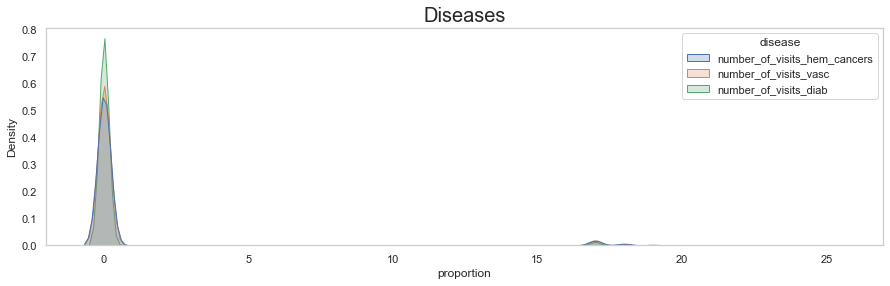

In [20]:
df_melt = pd.melt(df_grp, 
              value_vars=['number_of_visits_hem_cancers', 'number_of_visits_vasc', 'number_of_visits_diab'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Diseases", size=20)
print('')

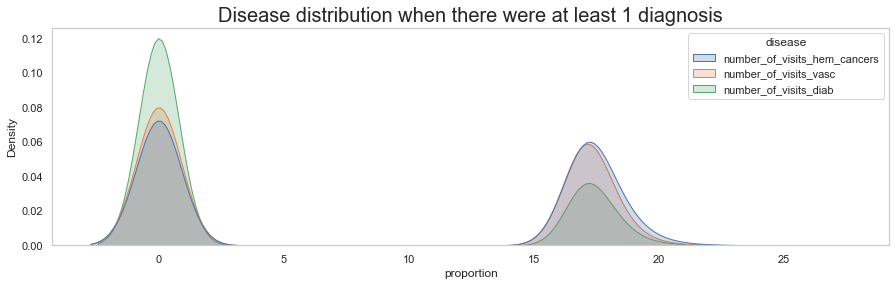

In [21]:
df_melt = pd.melt(df_grp[df_grp['number_of_visits_hem_cancers'] + df_grp['number_of_visits_vasc'] + df_grp['number_of_visits_diab'] > 0], 
              value_vars=['number_of_visits_hem_cancers', 'number_of_visits_vasc', 'number_of_visits_diab'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distribution when there were at least 1 diagnosis", size=20)
print('')